In [1]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import scipy.stats
mpl.rcParams['figure.dpi'] = 600

In [1]:
from tcga_dicts import *

# Part 0: Load Data

## Immune Cell Fractions

CIBERSORT result from [*The Immune Landscape of Cancer*](https://www.sciencedirect.com/science/article/pii/S1074761318301213) downloaded from [NIH PanCanAtlas](https://gdc.cancer.gov/about-data/publications/panimmune) includes are SampleID ([TCGA barcode](https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/)), Cancer Type ([TCGA Study Abbreviation](https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tcga-study-abbreviations)), and the abundance of 22 imuune cell types.

Note that the abundances in each row sum to 1. In other words, the abundance is the proportion of a cell type in the leukocyte compartment (see [below](#lf)), but not all cells (stroma, tumor, etc.).

In [2]:
data = pd.read_csv("TCGA.Kallisto.fullIDs.cibersort.relative.tsv", sep="\t")
data["SampleID"] = data["SampleID"].apply(lambda x: x.replace('.', '-'))
data

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE
0,TCGA-OR-A5JG-01A-11R-A29S-07,ACC,0.000000,0.048529,0.016052,0.046099,0.027037,0.290682,0.0,0.000000,...,0.363861,0.002715,0.026125,0.032788,0.000000,0.010290,0.009607,0.112,0.095797,1.047142
1,TCGA-OR-A5LG-01A-11R-A29S-07,ACC,0.007169,0.011125,0.007982,0.139842,0.000000,0.142742,0.0,0.001614,...,0.448243,0.000000,0.007464,0.126237,0.000000,0.000000,0.000000,0.104,0.103345,1.046163
2,TCGA-OR-A5JD-01A-11R-A29S-07,ACC,0.000023,0.014607,0.000000,0.104888,0.000000,0.174895,0.0,0.017928,...,0.329552,0.000000,0.009330,0.000000,0.190730,0.000000,0.000000,0.068,0.143259,1.039812
3,TCGA-OR-A5LH-01A-11R-A29S-07,ACC,0.047299,0.038180,0.000000,0.198591,0.000000,0.065240,0.0,0.043310,...,0.287939,0.000000,0.000576,0.000000,0.064725,0.000000,0.000000,0.388,0.028763,1.080553
4,TCGA-OR-A5KY-01A-11R-A29S-07,ACC,0.000000,0.024795,0.004418,0.051506,0.000000,0.225892,0.0,0.000000,...,0.486400,0.000000,0.042827,0.000000,0.017418,0.014769,0.000000,0.246,0.055621,1.073474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11368,TCGA-V4-A9EQ-01A-11R-A405-07,UVM,0.000000,0.028939,0.008894,0.000000,0.023294,0.015676,0.0,0.002279,...,0.521353,0.009128,0.000000,0.208036,0.000000,0.000000,0.000000,0.090,0.111538,1.060529
11369,TCGA-V4-A9EV-01A-11R-A405-07,UVM,0.000000,0.013299,0.025069,0.315356,0.000000,0.017361,0.0,0.095233,...,0.163671,0.015558,0.000000,0.061707,0.000000,0.000000,0.000000,0.002,0.347125,0.952021
11370,TCGA-V4-A9EY-01A-11R-A405-07,UVM,0.000000,0.032507,0.076160,0.061400,0.034359,0.000000,0.0,0.007778,...,0.431568,0.004550,0.000000,0.227797,0.000000,0.000000,0.000000,0.086,0.113888,1.041876
11371,TCGA-V4-A9EU-01A-11R-A405-07,UVM,0.000000,0.021228,0.010225,0.067985,0.003434,0.006675,0.0,0.004884,...,0.627631,0.000000,0.000000,0.147489,0.000000,0.000000,0.000000,0.096,0.107852,1.068155


In [3]:
tcga_study_abbr_dict = {
    "LAML": "Acute Myeloid Leukemia",
    "ACC": "Adrenocortical carcinoma",
    "BLCA": "Bladder Urothelial Carcinoma",
    "LGG": "Brain Lower Grade Glioma",
    "BRCA": "Breast invasive carcinoma",
    "CESC": "Cervical squamous cell carcinoma and endocervical adenocarcinoma",
    "CHOL": "Cholangiocarcinoma",
    "LCML": "Chronic Myelogenous Leukemia",
    "COAD": "Colon adenocarcinoma",
    "CNTL": "Controls",
    "ESCA": "Esophageal carcinoma",
    "FPPP": "FFPE Pilot Phase II",
    "GBM": "Glioblastoma multiforme",
    "HNSC": "Head and Neck squamous cell carcinoma",
    "KICH": "Kidney Chromophobe",
    "KIRC": "Kidney renal clear cell carcinoma",
    "KIRP": "Kidney renal papillary cell carcinoma",
    "LIHC": "Liver hepatocellular carcinoma",
    "LUAD": "Lung adenocarcinoma",
    "LUSC": "Lung squamous cell carcinoma",
    "DLBC": "Lymphoid Neoplasm Diffuse Large B-cell Lymphoma",
    "MESO": "Mesothelioma",
    "MISC": "Miscellaneous",
    "OV": "Ovarian serous cystadenocarcinoma",
    "PAAD": "Pancreatic adenocarcinoma",
    "PCPG": "Pheochromocytoma and Paraganglioma",
    "PRAD": "Prostate adenocarcinoma",
    "READ": "Rectum adenocarcinoma",
    "SARC": "Sarcoma",
    "SKCM": "Skin Cutaneous Melanoma",
    "STAD": "Stomach adenocarcinoma",
    "TGCT": "Testicular Germ Cell Tumors",
    "THYM": "Thymoma",
    "THCA": "Thyroid carcinoma",
    "UCS": "Uterine Carcinosarcoma",
    "UCEC": "Uterine Corpus Endometrial Carcinoma",
    "UVM": "Uveal Melanoma"
}

In [4]:
tcga_study_abbr_dict2 = {k: v + ' (' + k + ')' for k, v in tcga_study_abbr_dict.items()}
tcga_study_abbr_dict2

{'LAML': 'Acute Myeloid Leukemia (LAML)',
 'ACC': 'Adrenocortical carcinoma (ACC)',
 'BLCA': 'Bladder Urothelial Carcinoma (BLCA)',
 'LGG': 'Brain Lower Grade Glioma (LGG)',
 'BRCA': 'Breast invasive carcinoma (BRCA)',
 'CESC': 'Cervical squamous cell carcinoma and endocervical adenocarcinoma (CESC)',
 'CHOL': 'Cholangiocarcinoma (CHOL)',
 'LCML': 'Chronic Myelogenous Leukemia (LCML)',
 'COAD': 'Colon adenocarcinoma (COAD)',
 'CNTL': 'Controls (CNTL)',
 'ESCA': 'Esophageal carcinoma (ESCA)',
 'FPPP': 'FFPE Pilot Phase II (FPPP)',
 'GBM': 'Glioblastoma multiforme (GBM)',
 'HNSC': 'Head and Neck squamous cell carcinoma (HNSC)',
 'KICH': 'Kidney Chromophobe (KICH)',
 'KIRC': 'Kidney renal clear cell carcinoma (KIRC)',
 'KIRP': 'Kidney renal papillary cell carcinoma (KIRP)',
 'LIHC': 'Liver hepatocellular carcinoma (LIHC)',
 'LUAD': 'Lung adenocarcinoma (LUAD)',
 'LUSC': 'Lung squamous cell carcinoma (LUSC)',
 'DLBC': 'Lymphoid Neoplasm Diffuse Large B-cell Lymphoma (DLBC)',
 'MESO': 'Meso

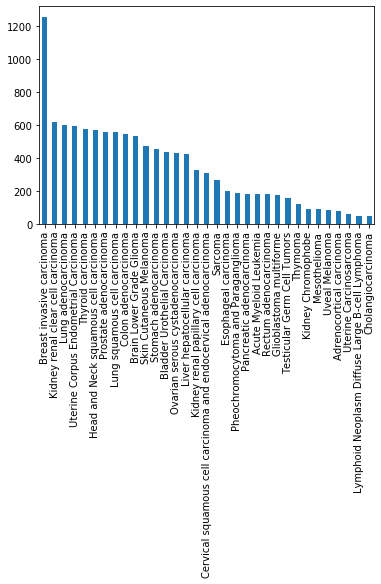

In [5]:
data["CancerType"].apply(tcga_study_abbr_dict.__getitem__).value_counts().plot(kind='bar')

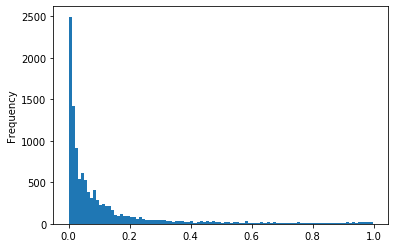

In [6]:
data['P.value'].plot(kind="hist", bins=100)

In [7]:
{'all': data['P.value'].apply(1.00.__ge__).sum(),
'0.05': data['P.value'].apply(0.05.__ge__).sum(),
'0.01': data['P.value'].apply(0.01.__ge__).sum()
}

{'all': 11373, '0.05': 6077, '0.01': 2893}

In [8]:
data['SampleID'].value_counts().where(lambda x: x > 1.0).dropna()

TCGA-A7-A13G-01B-04R-A22O-07    3.0
TCGA-AC-A2QH-01B-04R-A22O-07    3.0
TCGA-AC-A3OD-01B-06R-A22O-07    3.0
TCGA-A7-A26I-01B-06R-A22O-07    3.0
TCGA-A7-A26F-01B-04R-A22O-07    3.0
TCGA-A7-A0DC-01B-04R-A22O-07    3.0
TCGA-A7-A0DC-01A-11R-A00Z-07    3.0
TCGA-AK-3425-01A-02R-1277-07    2.0
TCGA-AC-A2QH-01A-11R-A18M-07    2.0
TCGA-37-4132-01A-01R-1100-07    2.0
TCGA-A6-5665-01B-03R-2302-07    2.0
TCGA-AZ-4615-01A-01R-1410-07    2.0
TCGA-FI-A2F8-01A-12R-A17B-07    2.0
TCGA-37-4133-01A-01R-1100-07    2.0
TCGA-HC-8261-01B-05R-2302-07    2.0
TCGA-AZ-4614-01A-01R-1410-07    2.0
TCGA-AK-3454-01A-02R-1277-07    2.0
TCGA-AZ-4315-01A-01R-1410-07    2.0
TCGA-A6-2684-01A-01R-1410-07    2.0
TCGA-38-4625-01A-01R-1206-07    2.0
TCGA-AK-3453-01A-02R-1277-07    2.0
TCGA-CA-5256-01A-01R-1410-07    2.0
TCGA-CM-4747-01A-01R-1410-07    2.0
TCGA-A6-2685-01A-01R-1410-07    2.0
TCGA-AW-A1PO-01A-12R-A157-07    2.0
TCGA-HC-7740-01B-04R-2302-07    2.0
TCGA-AK-3426-01A-02R-1325-07    2.0
TCGA-AA-3502-01A-01R-1410-07

In [9]:
data[data['SampleID'] == 'TCGA-A7-A0DC-01B-04R-A22O-07']

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE
1762,TCGA-A7-A0DC-01B-04R-A22O-07,BRCA,0.0,0.095566,0.045122,0.018111,0.130455,0.172505,0.0,0.0,...,0.115555,0.0,0.067555,0.251592,0.0,0.000000,0.0,0.108,0.099062,1.040622
1763,TCGA-A7-A0DC-01B-04R-A22O-07,BRCA,0.0,0.113939,0.040357,0.005743,0.067493,0.214965,0.0,0.0,...,0.125661,0.0,0.058962,0.278053,0.0,0.000000,0.0,0.138,0.078372,1.048953
1764,TCGA-A7-A0DC-01B-04R-A22O-07,BRCA,0.0,0.133703,0.046857,0.018552,0.031506,0.225782,0.0,0.0,...,0.104292,0.0,0.078465,0.211148,0.0,0.001334,0.0,0.244,0.045592,1.056600


## Leukocyte Fractions (LFs)

<a id='lf'></a>
Leukocyte fractions from [The Immune Landscape of Cancer](https://www.sciencedirect.com/science/article/pii/S1074761318301213) downloaded from [NIH PanCanAtlas](https://gdc.cancer.gov/about-data/publications/panimmune).

In [10]:
leuk = pd.read_csv("TCGA_all_leuk_estimate.masked.20170107.tsv", sep="\t", header=None)
leuk.columns = ['CancerType', 'SampleID', 'LF']
leuk

,CancerType,SampleID,LF
0,ACC,TCGA-OR-A5J1-01A-11D-A29J-05,0.046374
1,ACC,TCGA-OR-A5J2-01A-11D-A29J-05,0.057859
2,ACC,TCGA-OR-A5J3-01A-11D-A29J-05,0.048460
3,ACC,TCGA-OR-A5J4-01A-11D-A29J-05,0.043988
4,ACC,TCGA-OR-A5J5-01A-11D-A29J-05,0.016759
...,...,...,...
10812,TGCT,TCGA-ZM-AA0D-01A-11D-A436-05,0.578000
10813,TGCT,TCGA-ZM-AA0E-01A-12D-A436-05,0.512000
10814,TGCT,TCGA-ZM-AA0F-01A-21D-A436-05,0.625000
10815,TGCT,TCGA-ZM-AA0H-01A-11D-A436-05,0.431000


In [11]:
display(leuk.LF.min())
display(leuk.LF.max())

-9.29722165644888e-05

0.9642001238693829

In [12]:
leuk.LF[leuk.LF < 0] = 0

<ipython-input-12-9cbbd3800d77>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leuk.LF[leuk.LF < 0] = 0


## Merge CIBERSORT and LF

We first investigate the number of samples available.
Remember that the format of TCGA barcode is:


| Label        | Project | TSS | Participant | Sample & Vial | Portion & Analyte | Plate | Center |
|--------------|---------|-----|-------------|---------------|-------------------|-------|--------|
| Subscription | 0       | 1   | 2           | 3             | 4                 | 5     | 6      |
| Example      | TCGA    | OR  | A5J1        | 01A           | 11D               | A29J  | 05     |

If we use Label-Project-TSS-Participant-Sample&Vial as the identifier, there are 10103 matched ones. It goes down to zero if we use up to Portion&Analyte. In fact, the CIBERSORT is based on RNA, while the LF is based on the DNA sample (by methylation analysis).

Finally, we use Label-Project-TSS-Participant-Sample&Vial-Portion, but exclude the Analyter, Plate, and Center as our identifier to match the samples.

Also note that there are "duplicates" in the original tables. For CIBERSORT, we keep the one with lowest p-value. For LF, we take the average.

It is worth noting that "match" here shall not be confused with "matched samples" in "paired test".

In [13]:
id1 = set(data['SampleID'].apply(lambda x: '-'.join(x.split('-')[0:4])))
id2 = set(leuk['SampleID'].apply(lambda x: '-'.join(x.split('-')[0:4])))
{
    '1': len(id1),
    '2': len(id2),
    'intersection': len(id1.intersection(id2))
}

{'1': 11273, '2': 10770, 'intersection': 10103}

In [14]:
id1 = set(data['SampleID'].apply(lambda x: '-'.join(x.split('-')[0:5])))
id2 = set(leuk['SampleID'].apply(lambda x: '-'.join(x.split('-')[0:5])))
{
    '1': len(id1),
    '2': len(id2),
    'intersection': len(id1.intersection(id2))
}

{'1': 11275, '2': 10782, 'intersection': 0}

In [15]:
id1 = set(data['SampleID'].apply(lambda x: '-'.join(x.split('-')[0:4] + [x.split('-')[4][0:2]])))
id2 = set(leuk['SampleID'].apply(lambda x: '-'.join(x.split('-')[0:4] + [x.split('-')[4][0:2]])))
common_id = id1.intersection(id2)
{
    '1': len(id1),
    '2': len(id2),
    'intersection': len(common_id)
}

{'1': 11275, '2': 10782, 'intersection': 10039}

In [16]:
merged = pd.DataFrame()
for id in common_id:
    temp = data[data['SampleID'].apply(lambda x: id in x)]
    temp.loc[:, 'LF'] = leuk.loc[leuk.loc[:, 'SampleID'].apply(lambda x: id in x), 'LF'].mean()
    merged = merged.append(temp.loc[temp.loc[:, 'P.value'].idxmax()])

/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [17]:
merged = merged[data.columns.tolist() + ['LF']]

In [18]:
merged

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,LF
6674,TCGA-92-7341-01A-31R-2045-07,LUSC,0.147873,0.000000,0.087686,0.033431,0.0,0.170879,0.000000,0.000000,...,0.000000,0.019767,0.018538,0.001042,0.0,0.004651,0.006,0.287252,0.969659,0.216818
7939,TCGA-CH-5754-01A-11R-1580-07,PRAD,0.065331,0.000000,0.097379,0.145830,0.0,0.144164,0.000000,0.135648,...,0.011441,0.000000,0.023868,0.000000,0.0,0.000000,0.014,0.229421,1.006918,0.248506
11182,TCGA-BS-A0V7-01A-21R-A118-07,UCEC,0.000000,0.129441,0.112427,0.166960,0.0,0.066348,0.007972,0.108577,...,0.010174,0.004734,0.081979,0.000000,0.0,0.000285,0.004,0.366437,0.936339,0.138962
1419,TCGA-A2-A0CQ-01A-21R-A034-07,BRCA,0.000000,0.044607,0.000000,0.198327,0.0,0.041238,0.000000,0.018438,...,0.006661,0.000000,0.059281,0.000000,0.0,0.002902,0.012,0.221909,1.001612,0.120546
6205,TCGA-05-5420-01A-01R-1628-07,LUAD,0.031664,0.000000,0.013226,0.087401,0.0,0.115560,0.052406,0.055071,...,0.140423,0.000000,0.020737,0.000000,0.0,0.014643,0.216,0.048965,1.068250,0.571093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3172,TCGA-CV-5432-01A-02R-1686-07,HNSC,0.127065,0.000000,0.261089,0.105192,0.0,0.023960,0.000000,0.042882,...,0.057583,0.000000,0.039449,0.000000,0.0,0.002197,0.002,0.437382,0.903511,0.179283
2824,TCGA-L5-A8NQ-01A-11R-A36D-31,ESCA,0.000000,0.038928,0.011305,0.114216,0.0,0.036888,0.000000,0.100739,...,0.000000,0.000000,0.053488,0.000000,0.0,0.000000,0.096,0.101506,1.059170,0.392468
9431,TCGA-FP-8210-01A-11R-2343-13,STAD,0.187019,0.099927,0.000176,0.146384,0.0,0.115863,0.000000,0.066405,...,0.000000,0.018263,0.072636,0.000000,0.0,0.000000,0.002,0.337942,0.949999,0.488038
8279,TCGA-KK-A8I8-01A-11R-A36G-07,PRAD,0.002727,0.092736,0.019580,0.202959,0.0,0.177791,0.000000,0.036568,...,0.014536,0.000000,0.064118,0.000000,0.0,0.000000,0.222,0.065246,1.063335,0.066327


Multiply abundance of cell types with the leukocyte fraction.

In [19]:
merged_adjusted = merged.copy()
for i in range(merged_adjusted.shape[0]):
    merged_adjusted.iloc[i, cell_types] *= merged.iloc[i, 27]
merged_adjusted

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,LF
6674,TCGA-92-7341-01A-31R-2045-07,LUSC,0.032062,0.000000,0.019012,0.007248,0.0,0.037050,0.000000,0.000000,...,0.000000,0.004286,0.004019,0.000226,0.0,0.001008,0.006,0.287252,0.969659,0.216818
7939,TCGA-CH-5754-01A-11R-1580-07,PRAD,0.016235,0.000000,0.024199,0.036240,0.0,0.035825,0.000000,0.033709,...,0.002843,0.000000,0.005931,0.000000,0.0,0.000000,0.014,0.229421,1.006918,0.248506
11182,TCGA-BS-A0V7-01A-21R-A118-07,UCEC,0.000000,0.017987,0.015623,0.023201,0.0,0.009220,0.001108,0.015088,...,0.001414,0.000658,0.011392,0.000000,0.0,0.000040,0.004,0.366437,0.936339,0.138962
1419,TCGA-A2-A0CQ-01A-21R-A034-07,BRCA,0.000000,0.005377,0.000000,0.023907,0.0,0.004971,0.000000,0.002223,...,0.000803,0.000000,0.007146,0.000000,0.0,0.000350,0.012,0.221909,1.001612,0.120546
6205,TCGA-05-5420-01A-01R-1628-07,LUAD,0.018083,0.000000,0.007553,0.049914,0.0,0.065995,0.029929,0.031451,...,0.080195,0.000000,0.011843,0.000000,0.0,0.008363,0.216,0.048965,1.068250,0.571093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3172,TCGA-CV-5432-01A-02R-1686-07,HNSC,0.022781,0.000000,0.046809,0.018859,0.0,0.004296,0.000000,0.007688,...,0.010324,0.000000,0.007073,0.000000,0.0,0.000394,0.002,0.437382,0.903511,0.179283
2824,TCGA-L5-A8NQ-01A-11R-A36D-31,ESCA,0.000000,0.015278,0.004437,0.044826,0.0,0.014477,0.000000,0.039537,...,0.000000,0.000000,0.020992,0.000000,0.0,0.000000,0.096,0.101506,1.059170,0.392468
9431,TCGA-FP-8210-01A-11R-2343-13,STAD,0.091272,0.048768,0.000086,0.071441,0.0,0.056546,0.000000,0.032408,...,0.000000,0.008913,0.035449,0.000000,0.0,0.000000,0.002,0.337942,0.949999,0.488038
8279,TCGA-KK-A8I8-01A-11R-A36G-07,PRAD,0.000181,0.006151,0.001299,0.013462,0.0,0.011792,0.000000,0.002425,...,0.000964,0.000000,0.004253,0.000000,0.0,0.000000,0.222,0.065246,1.063335,0.066327


## Label samples
Label samples with its type and patient ID (i.e., Label-Project-TSS-Participant).

In [20]:
tcga_sample_type_dict = {
    "01": "Primary Solid Tumor",
    "02": "Recurrent Solid Tumor",
    "03": "Primary Blood Derived Cancer - Peripheral Blood",
    "04": "Recurrent Blood Derived Cancer - Bone Marrow",
    "05": "Additional - New Primary",
    "06": "Metastatic",
    "07": "Additional Metastatic",
    "08": "Human Tumor Original Cells",
    "09": "Primary Blood Derived Cancer - Bone Marrow",
    "10": "Blood Derived Normal",
    "11": "Solid Tissue Normal",
    "12": "Buccal Cell Normal",
    "13": "EBV Immortalized Normal",
    "14": "Bone Marrow Normal",
    "15": "sample type 15",
    "16": "sample type 16",
    "20": "Control Analyte",
    "40": "Recurrent Blood Derived Cancer - Peripheral Blood",
    "50": "Cell Lines",
    "60": "Primary Xenograft Tissue",
    "61": "Cell Line Derived Xenograft Tissue",
    "99": "sample type 99"
}

In [21]:
f = lambda x: tcga_sample_type_dict[x.split('-')[3][0:2]]
merged_adjusted['SampleType'] = merged_adjusted["SampleID"].apply(f)

In [22]:
f = lambda x: '-'.join(x.split('-')[0:3])
merged_adjusted['PatientID'] = merged_adjusted["SampleID"].apply(f)

In [23]:
merged_adjusted

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,LF,SampleType,PatientID
6674,TCGA-92-7341-01A-31R-2045-07,LUSC,0.032062,0.000000,0.019012,0.007248,0.0,0.037050,0.000000,0.000000,...,0.004019,0.000226,0.0,0.001008,0.006,0.287252,0.969659,0.216818,Primary Solid Tumor,TCGA-92-7341
7939,TCGA-CH-5754-01A-11R-1580-07,PRAD,0.016235,0.000000,0.024199,0.036240,0.0,0.035825,0.000000,0.033709,...,0.005931,0.000000,0.0,0.000000,0.014,0.229421,1.006918,0.248506,Primary Solid Tumor,TCGA-CH-5754
11182,TCGA-BS-A0V7-01A-21R-A118-07,UCEC,0.000000,0.017987,0.015623,0.023201,0.0,0.009220,0.001108,0.015088,...,0.011392,0.000000,0.0,0.000040,0.004,0.366437,0.936339,0.138962,Primary Solid Tumor,TCGA-BS-A0V7
1419,TCGA-A2-A0CQ-01A-21R-A034-07,BRCA,0.000000,0.005377,0.000000,0.023907,0.0,0.004971,0.000000,0.002223,...,0.007146,0.000000,0.0,0.000350,0.012,0.221909,1.001612,0.120546,Primary Solid Tumor,TCGA-A2-A0CQ
6205,TCGA-05-5420-01A-01R-1628-07,LUAD,0.018083,0.000000,0.007553,0.049914,0.0,0.065995,0.029929,0.031451,...,0.011843,0.000000,0.0,0.008363,0.216,0.048965,1.068250,0.571093,Primary Solid Tumor,TCGA-05-5420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3172,TCGA-CV-5432-01A-02R-1686-07,HNSC,0.022781,0.000000,0.046809,0.018859,0.0,0.004296,0.000000,0.007688,...,0.007073,0.000000,0.0,0.000394,0.002,0.437382,0.903511,0.179283,Primary Solid Tumor,TCGA-CV-5432
2824,TCGA-L5-A8NQ-01A-11R-A36D-31,ESCA,0.000000,0.015278,0.004437,0.044826,0.0,0.014477,0.000000,0.039537,...,0.020992,0.000000,0.0,0.000000,0.096,0.101506,1.059170,0.392468,Primary Solid Tumor,TCGA-L5-A8NQ
9431,TCGA-FP-8210-01A-11R-2343-13,STAD,0.091272,0.048768,0.000086,0.071441,0.0,0.056546,0.000000,0.032408,...,0.035449,0.000000,0.0,0.000000,0.002,0.337942,0.949999,0.488038,Primary Solid Tumor,TCGA-FP-8210
8279,TCGA-KK-A8I8-01A-11R-A36G-07,PRAD,0.000181,0.006151,0.001299,0.013462,0.0,0.011792,0.000000,0.002425,...,0.004253,0.000000,0.0,0.000000,0.222,0.065246,1.063335,0.066327,Primary Solid Tumor,TCGA-KK-A8I8


# Basic statistics

In [24]:
f = lambda x: tcga_sample_type_dict[x.split('-')[3][0:2]]
all_data = merged_adjusted.copy()
all_data["SampleType"] = all_data["SampleID"].apply(f)
all_data.groupby(["CancerType", "SampleType"]).SampleID.count().to_frame()

SampleID
CancerType SampleType                        
ACC        Primary Solid Tumor             79
BLCA       Primary Solid Tumor            411
BRCA       Metastatic                       7
           Primary Solid Tumor           1084
CESC       Metastatic                       2
           Primary Solid Tumor            304
CHOL       Primary Solid Tumor             36
COAD       Metastatic                       1
           Primary Solid Tumor            466
           Recurrent Solid Tumor            1
ESCA       Metastatic                       1
           Primary Solid Tumor            184
GBM        Primary Solid Tumor            127
           Recurrent Solid Tumor           13
HNSC       Metastatic                       2
           Primary Solid Tumor            520
KICH       Primary Solid Tumor             66
KIRC       Additional - New Primary         1
           Primary Solid Tumor            490
KIRP       Additional - New Primary         1
           Primary Solid Tumor            280
LGG        Primary Solid Tumor            513
           Recurrent Solid Tumor           18
LIHC       Primary Solid Tumor            371
           Recurrent Solid Tumor            3
LUAD       Primary Solid Tumor            525
           Recurrent Solid Tumor            2
LUSC       Primary Solid Tumor            501
MESO       Primary Solid Tumor             87
OV         Primary Solid Tumor            419
           Recurrent Solid Tumor            7
PAAD       Metastatic                       1
           Primary Solid Tumor            178
PCPG       Additional - New Primary         3
           Metastatic                       2
           Primary Solid Tumor            179
PRAD       Metastatic                       1
           Primary Solid Tumor            501
READ       Primary Solid Tumor            164
           Recurrent Solid Tumor            1
SARC       Metastatic                       1
           Primary Solid Tumor            259
           Recurrent Solid Tumor            3
SKCM       Additional Metastatic            1
           Metastatic                     367
           Primary Solid Tumor            103
STAD       Primary Solid Tumor            416
TGCT       Additional - New Primary         4
           Primary Solid Tumor            133
THCA       Metastatic                       8
           Primary Solid Tumor            505
UCEC       Primary Solid Tumor            549
           Recurrent Solid Tumor            1
UCS        Primary Solid Tumor             57
UVM        Primary Solid Tumor             80

In [25]:
all_data.SampleType.unique().tolist()

['Primary Solid Tumor',
 'Metastatic',
 'Recurrent Solid Tumor',
 'Additional Metastatic',
 'Additional - New Primary']

In [26]:
sample_size = pd.crosstab(all_data["CancerType"], all_data["SampleType"])
sample_size.T.style

CancerType,ACC,BLCA,BRCA,CESC,CHOL,COAD,ESCA,GBM,HNSC,KICH,KIRC,KIRP,LGG,LIHC,LUAD,LUSC,MESO,OV,PAAD,PCPG,PRAD,READ,SARC,SKCM,STAD,TGCT,THCA,UCEC,UCS,UVM
SampleType,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Additional - New Primary,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,3,0,0,0,0,0,4,0,0,0,0
Additional Metastatic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Metastatic,0,0,7,2,0,1,1,0,2,0,0,0,0,0,0,0,0,0,1,2,1,0,1,367,0,0,8,0,0,0
Primary Solid Tumor,79,411,1084,304,36,466,184,127,520,66,490,280,513,371,525,501,87,419,178,179,501,164,259,103,416,133,505,549,57,80
Recurrent Solid Tumor,0,0,0,0,0,1,0,13,0,0,0,0,18,3,2,0,0,7,0,0,0,1,3,0,0,0,0,1,0,0


In [27]:
all_data

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,LF,SampleType,PatientID
6674,TCGA-92-7341-01A-31R-2045-07,LUSC,0.032062,0.000000,0.019012,0.007248,0.0,0.037050,0.000000,0.000000,...,0.004019,0.000226,0.0,0.001008,0.006,0.287252,0.969659,0.216818,Primary Solid Tumor,TCGA-92-7341
7939,TCGA-CH-5754-01A-11R-1580-07,PRAD,0.016235,0.000000,0.024199,0.036240,0.0,0.035825,0.000000,0.033709,...,0.005931,0.000000,0.0,0.000000,0.014,0.229421,1.006918,0.248506,Primary Solid Tumor,TCGA-CH-5754
11182,TCGA-BS-A0V7-01A-21R-A118-07,UCEC,0.000000,0.017987,0.015623,0.023201,0.0,0.009220,0.001108,0.015088,...,0.011392,0.000000,0.0,0.000040,0.004,0.366437,0.936339,0.138962,Primary Solid Tumor,TCGA-BS-A0V7
1419,TCGA-A2-A0CQ-01A-21R-A034-07,BRCA,0.000000,0.005377,0.000000,0.023907,0.0,0.004971,0.000000,0.002223,...,0.007146,0.000000,0.0,0.000350,0.012,0.221909,1.001612,0.120546,Primary Solid Tumor,TCGA-A2-A0CQ
6205,TCGA-05-5420-01A-01R-1628-07,LUAD,0.018083,0.000000,0.007553,0.049914,0.0,0.065995,0.029929,0.031451,...,0.011843,0.000000,0.0,0.008363,0.216,0.048965,1.068250,0.571093,Primary Solid Tumor,TCGA-05-5420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3172,TCGA-CV-5432-01A-02R-1686-07,HNSC,0.022781,0.000000,0.046809,0.018859,0.0,0.004296,0.000000,0.007688,...,0.007073,0.000000,0.0,0.000394,0.002,0.437382,0.903511,0.179283,Primary Solid Tumor,TCGA-CV-5432
2824,TCGA-L5-A8NQ-01A-11R-A36D-31,ESCA,0.000000,0.015278,0.004437,0.044826,0.0,0.014477,0.000000,0.039537,...,0.020992,0.000000,0.0,0.000000,0.096,0.101506,1.059170,0.392468,Primary Solid Tumor,TCGA-L5-A8NQ
9431,TCGA-FP-8210-01A-11R-2343-13,STAD,0.091272,0.048768,0.000086,0.071441,0.0,0.056546,0.000000,0.032408,...,0.035449,0.000000,0.0,0.000000,0.002,0.337942,0.949999,0.488038,Primary Solid Tumor,TCGA-FP-8210
8279,TCGA-KK-A8I8-01A-11R-A36G-07,PRAD,0.000181,0.006151,0.001299,0.013462,0.0,0.011792,0.000000,0.002425,...,0.004253,0.000000,0.0,0.000000,0.222,0.065246,1.063335,0.066327,Primary Solid Tumor,TCGA-KK-A8I8


In [28]:
cell_types = ['B.cells.naive', 'B.cells.memory', 'Plasma.cells', 'T.cells.CD8',
       'T.cells.CD4.naive', 'T.cells.CD4.memory.resting',
       'T.cells.CD4.memory.activated', 'T.cells.follicular.helper',
       'T.cells.regulatory..Tregs.', 'T.cells.gamma.delta', 'NK.cells.resting',
       'NK.cells.activated', 'Monocytes', 'Macrophages.M0', 'Macrophages.M1',
       'Macrophages.M2', 'Dendritic.cells.resting',
       'Dendritic.cells.activated', 'Mast.cells.resting',
       'Mast.cells.activated', 'Eosinophils', 'Neutrophils']

In [29]:
all_data['Leukocytes.all'] = all_data[cell_types].sum(1)

all_data['T.cells.all'] = all_data[['T.cells.CD8',
                                    'T.cells.CD4.naive',
                                    'T.cells.CD4.memory.resting',
                                    'T.cells.CD4.memory.activated',
                                    'T.cells.follicular.helper',
                                    'T.cells.regulatory..Tregs.',
                                    'T.cells.gamma.delta']].sum(1)

all_data['B.cells.all'] = all_data[['B.cells.naive', 'B.cells.memory']].sum(1)

all_data['Nk.cells.all'] = all_data[['NK.cells.resting', 'NK.cells.activated']].sum(1)

all_data['Macrophages.all'] = all_data[['Macrophages.M0', 'Macrophages.M1', 'Macrophages.M2']].sum(1)

all_data['Dendritic.cells.all'] = all_data[['Dendritic.cells.resting', 'Dendritic.cells.activated']].sum(1)

all_data['Mast.cells.all'] = all_data[['Mast.cells.resting', 'Mast.cells.activated']].sum(1)



augmented_cell_types = cell_types + ['T.cells.all', 'B.cells.all', 'Nk.cells.all', 'Macrophages.all', 
                                     'Dendritic.cells.all', 'Mast.cells.all', 'Leukocytes.all']

## Mean and variance

Sample mean $\bar{x}$, confidence interval $(\bar{x}_L, \bar{x}_U)$.
Sample standard deviation $s$, confidence interval $(s_L, s_U)$.

\begin{align}
\bar{x} & = \frac{\sum{}x_i}{n} \\
s & = \sqrt{\frac{\sum{}(x_i - \bar{x})^2}{n}} \\
\bar{x}_L, \bar{x}_U & = \bar{x} \pm t_{1-\alpha/2, \nu}\frac{s}{\sqrt{n}} \\
s_L & = \sqrt{\frac{(n-1)s^2}{\chi^2_{1-\alpha/2, \nu}}} \\
s_U & = \sqrt{\frac{(n-1)s^2}{\chi^2_{\alpha/2, \nu}}} \\
\end{align}

In this context, degree of freedom $\nu = n - 1$.

In [53]:
sample_size.columns

Index(['Additional - New Primary', 'Additional Metastatic', 'Metastatic',
       'Primary Solid Tumor', 'Recurrent Solid Tumor'],
      dtype='object', name='SampleType')

In [49]:
a = 0.05

num_data = all_data[augmented_cell_types]

sanitize = lambda x: 0.0 if x < 0 else 1.0 if x > 1 else x

for sample_type in sample_size.columns:
    sample_type_mean = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_mean_lower = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_mean_upper = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_sd = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_sd_lower = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_sd_upper = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)

    for j in sample_type_mean.columns:
        n = ((all_data.CancerType == j) & (all_data.SampleType == sample_type)).sum()

        # Mean
        sample_type_mean.loc[:, j] = num_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].mean(axis=0)

        # Standard deviation
        sample_type_sd.loc[:, j] = all_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].std(ddof=1, axis=0)
        
        # Mean CI
        err = scipy.stats.t.ppf(1 - a / 2, n - 1) * sample_type_sd.loc[:, j] / np.sqrt(n)
        sample_type_mean_lower.loc[:, j] = sample_type_mean.loc[:, j] - err
        sample_type_mean_upper.loc[:, j] = sample_type_mean.loc[:, j] + err
        
        # Standard deviation CI
        sample_type_sd_lower.loc[:, j] = np.sqrt((n - 1) * sample_type_sd.loc[:, j] ** 2 / scipy.stats.chi2.ppf(1 - a / 2, n - 1))
        sample_type_sd_upper.loc[:, j] = np.sqrt((n - 1) * sample_type_sd.loc[:, j] ** 2 / scipy.stats.chi2.ppf(a / 2, n - 1))

    index_str_len = sample_type_mean.index.to_series().apply(lambda x: len(x)).max()
    index_str_len
        
    with pd.ExcelWriter(sample_type + " all.xlsx", engine="xlsxwriter") as writer:
        sample_type_mean.to_excel(writer, sheet_name="mean")
        sample_type_mean_lower.applymap(sanitize).to_excel(writer, sheet_name="mean 95% CI lower")
        sample_type_mean_upper.applymap(sanitize).to_excel(writer, sheet_name="mean 95% CI upper")
        
        sample_type_sd.to_excel(writer, sheet_name="sd")
        sample_type_sd_lower.to_excel(writer, sheet_name="sd 95% CI lower")
        sample_type_sd_upper.to_excel(writer, sheet_name="sd 95% CI upper")
        for i in writer.sheets:
            writer.sheets[i].set_column('A:A', index_str_len)

In [51]:
with pd.ExcelWriter("all.xlsx", engine="xlsxwriter") as writer:
    sample_size.T.to_excel(writer, sheet_name="summary")

In [43]:
scipy.stats.t.ppf(1 - a / 2, n - 1) * sample_type_sd.loc[:, j] / n

ZeroDivisionError: float division by zero

In [37]:
a = 0.05

loglog = lambda x: np.log(-np.log(x))
expexp = lambda x: np.exp(-np.exp(x))

num_data = all_data[augmented_cell_types]

loglog_num_data = loglog(num_data)

for sample_type in sample_size.columns:
    sample_type_mean = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_loglog_mean = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_loglog_sd = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_mean_lower = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_mean_upper = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_sd = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_sd_lower = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_sd_upper = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)

    for j in sample_type_mean.columns:
        n = ((all_data.CancerType == j) & (all_data.SampleType == sample_type)).sum()

        # Mean
        sample_type_mean.loc[:, j] = num_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].mean(axis=0)
        sample_type_loglog_mean.loc[:, j] = loglog_num_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].mean(axis=0)
        sample_type_loglog_sd.loc[:, j] = loglog_num_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].std(ddof=1, axis=0)

        # Mean CI
        err = scipy.stats.t.ppf(1 - a / 2, n - 1) * sample_type_loglog_sd.loc[:, j] / np.sqrt(n)
        sample_type_mean_lower.loc[:, j] = (sample_type_loglog_mean.loc[:, j] + err).apply(expexp)
        sample_type_mean_upper.loc[:, j] = (sample_type_loglog_mean.loc[:, j] - err).apply(expexp)

        # Standard deviation
        sample_type_sd.loc[:, j] = all_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].std(ddof=1, axis=0)

        
        # Standard deviation CI
        sample_type_sd_lower.loc[:, j] = np.sqrt((n - 1) * sample_type_sd.loc[:, j] ** 2 / scipy.stats.chi2.ppf(1 - a / 2, n - 1))
        sample_type_sd_upper.loc[:, j] = np.sqrt((n - 1) * sample_type_sd.loc[:, j] ** 2 / scipy.stats.chi2.ppf(a / 2, n - 1))

    index_str_len = sample_type_mean.index.to_series().apply(lambda x: len(x)).max()
    index_str_len
        
    with pd.ExcelWriter(sample_type + ".xlsx", engine="xlsxwriter") as writer:
        sample_type_mean.to_excel(writer, sheet_name="mean")
        sample_type_mean_lower.to_excel(writer, sheet_name="mean 95% CI lower")
        sample_type_mean_upper.to_excel(writer, sheet_name="mean 95% CI upper")
        (sample_type_mean_upper - sample_type_mean_lower).to_excel(writer, sheet_name="mean 95% CI size")
        
        sample_type_sd.to_excel(writer, sheet_name="sd")
        sample_type_sd_lower.to_excel(writer, sheet_name="sd 95% CI lower")
        sample_type_sd_upper.to_excel(writer, sheet_name="sd 95% CI upper")
        (sample_type_sd_upper - sample_type_sd_lower).to_excel(writer, sheet_name="sd 95% CI size")
        for i in writer.sheets:
            writer.sheets[i].set_column('A:A', index_str_len)

<ipython-input-37-2c74ce31bdce>:3: RuntimeWarning: divide by zero encountered in log
  loglog = lambda x: np.log(-np.log(x))


FileCreateError: [Errno 13] Permission denied: 'Primary Solid Tumor.xlsx'

In [39]:
loglog_num_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].mean(axis=0)

B.cells.naive                        inf
B.cells.memory                       inf
Plasma.cells                         inf
T.cells.CD8                          inf
T.cells.CD4.naive                    inf
T.cells.CD4.memory.resting           inf
T.cells.CD4.memory.activated         inf
T.cells.follicular.helper            inf
T.cells.regulatory..Tregs.           inf
T.cells.gamma.delta                  inf
NK.cells.resting                     inf
NK.cells.activated                   inf
Monocytes                            inf
Macrophages.M0                       inf
Macrophages.M1                       inf
Macrophages.M2                  1.497889
Dendritic.cells.resting              inf
Dendritic.cells.activated            inf
Mast.cells.resting                   inf
Mast.cells.activated                 inf
Eosinophils                          inf
Neutrophils                          inf
T.cells.all                     1.576024
B.cells.all                          inf
Nk.cells.all    

In [34]:
num_data.min()

B.cells.naive                   0.0
B.cells.memory                  0.0
Plasma.cells                    0.0
T.cells.CD8                     0.0
T.cells.CD4.naive               0.0
T.cells.CD4.memory.resting      0.0
T.cells.CD4.memory.activated    0.0
T.cells.follicular.helper       0.0
T.cells.regulatory..Tregs.      0.0
T.cells.gamma.delta             0.0
NK.cells.resting                0.0
NK.cells.activated              0.0
Monocytes                       0.0
Macrophages.M0                  0.0
Macrophages.M1                  0.0
Macrophages.M2                  0.0
Dendritic.cells.resting         0.0
Dendritic.cells.activated       0.0
Mast.cells.resting              0.0
Mast.cells.activated            0.0
Eosinophils                     0.0
Neutrophils                     0.0
T.cells.all                     0.0
B.cells.all                     0.0
Nk.cells.all                    0.0
Macrophages.all                 0.0
Dendritic.cells.all             0.0
Mast.cells.all              